In [ ]:
# Import Packages

In [8]:
import os
import numpy as np
from PIL import Image
import json

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Flattening and loading of pre-processed DCT coefficients along with the lables
# Apart from VidTIMIT-DFTIMIT dataset, for training and evaluation
# only 80,000 real and fake DCT coefficients are considered 

In [12]:
Encode = {
    'Fake':0,
    'Real':1
}

images = []
labels = []
total_images = 0
f = 0
r = 0
for dirs,subdirs,files in os.walk('/content/DCT'):
  cnt = 0
  cnt_img = 0
  for file in files:
    img_path = os.path.join(dirs,file)
    img_data = np.load(img_path)
    img_data = img_data.flatten(order='C')
    st = img_path.split('/')
    if (st[3] == 'Fake' and f == 80000):
      break
    elif (st[3] == 'Real' and r == 80000):
      break
    if (st[3] == 'Fake'):
      f += 1
    else:
      r += 1
    labels.append(Encode[st[3]])
    images.append(img_data)
print(f'Total Images: {len(images)}')

Total Images: 68025


In [ ]:
# Splitting of Dataset into 80-20 ratio for training and evaluation

In [14]:
images = np.array(images,dtype=np.float32) / 255.0
labels = np.array(labels)
image_train,image_test,y_train,y_test = train_test_split(images,labels,test_size=0.2,random_state=42,)

image_train.shape

(54420, 256)

In [ ]:
# Creation of Single-Branch CNNs from the Dual-Branch architecture for the ablation experiments

In [15]:
def build_model():
  Inputs = tf.keras.layers.Input(shape=(256,1) , name = 'DCT_Input')
  x_dct = tf.keras.layers.Conv1D(100,3,activation='relu',padding='same')(Inputs)
  x_dct = tf.keras.layers.Conv1D(100,3,activation='relu',padding='same')(x_dct)
  x_dct = tf.keras.layers.MaxPooling1D(2)(x_dct)
  x_dct = tf.keras.layers.Conv1D(100,3,activation='relu',padding='same')(x_dct)
  x_dct = tf.keras.layers.Conv1D(100,3,activation='relu',padding='same')(x_dct)
  x_dct = tf.keras.layers.MaxPooling1D(2)(x_dct)


  flatten_dct = tf.keras.layers.Flatten()(x_dct)
  combined = tf.keras.layers.Dense(256, activation='relu')(flatten_dct)
  combined = tf.keras.layers.Dropout(0.5)(combined)

  output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)
  model = tf.keras.models.Model(inputs=Inputs, outputs=output)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  return model


In [ ]:
# Custom Callback used to deal with overfitting 
# Saves only those checkpoints where difference between train accuracy and val accuracy is minimum
# Also saves the checkpoints where the val accuracy is better than the previous stored val accuracy

In [16]:
class MinDiffCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_accuracy', prev_val = -10**9 ,min_delta=0.02):
        super(MinDiffCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.min_delta = min_delta      # Minimum acceptable difference
        self.best_diff = np.inf         # Initialize with infinity
        self.best_weights = None
        self.prev_val = prev_val

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Get current metrics
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')

        if val_acc is None or train_acc is None:
            return

        # Calculate absolute difference
        current_diff = abs(train_acc - val_acc)

        # Check if difference is below threshold and better than previous best
        if current_diff < self.min_delta or current_diff < self.best_diff:

            # Save the model
            if self.prev_val < val_acc:
                self.prev_val=val_acc
                self.model.save_weights(self.filepath, overwrite=True)
                print(f"\nDifference improved from {self.best_diff:.4f} to {current_diff:.4f}")
                self.best_diff = current_diff
                self.best_weights = self.model.get_weights()
                print(f"Model saved with train-val difference: {current_diff:.4f}")

    def on_train_end(self, logs=None):
        # Restore the best weights found
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"\nTraining complete. Restoring weights with best difference: {self.best_diff:.4f}")

In [17]:
checkpoint = MinDiffCheckpoint(
    filepath='checkPoint_CDF.keras',         # Name of saved checkpoint
    monitor='val_accuracy',
    min_delta=0.1
)

In [ ]:
# Implementation of 10-fold cross validation
# Only required for the data of VidTIMIT-DFTIMIT

In [18]:
max_k = 10                                 # Value of k-fold CV
with open('../DCT/Model.json','r') as f:   # Path where results of each fold will be stored
    Models = json.load(f)

it = len(Models) + 1
for i in range(it,max_k+1):
    print(f'Fold no: {i}')

    # Splitting of data for each fold 
    image_train,image_test,y_train,y_test = train_test_split(images,labels,test_size=0.2,random_state=42,)

    model = build_model()                    # creation of model for each fold
    initial_weights = model.get_weights()
    print("Training samples:", len(y_train))
    history = model.fit(
        image_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data = (image_test,y_test),
        callbacks = [checkpoint]
    )
    model.save(f'Fold_{i}_model.keras')
    accuracy = history.history['accuracy']          # Training accuracy per epoch
    val_loss = history.history['val_loss']          # Validation loss per epoch
    val_accuracy = history.history['val_accuracy']

    Fold = {}
    Fold['train_accuracy'] = accuracy
    Fold['val_accuracy'] = val_accuracy
    Fold['val_loss'] = val_loss

    Models.append(Fold)
    with open('../DCT/Model.json', 'w') as f:
        json.dump(Models, f)
    if i < max_k:
        model.set_weights(initial_weights)
    print(f'fold no {i} complete and stored')

Fold no: 1
Training samples: 54420
Epoch 1/20
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7117 - loss: 0.5204
Difference improved from inf to 0.1130
Model saved with train-val difference: 0.1130
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7118 - loss: 0.5203 - val_accuracy: 0.9433 - val_loss: 0.1474
Epoch 2/20
1698/1701 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9631 - loss: 0.1082
Difference improved from 0.1130 to 0.0099
Model saved with train-val difference: 0.0099
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9631 - loss: 0.1082 - val_accuracy: 0.9817 - val_loss: 0.0560
Epoch 3/20
1692/1701 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9861 - loss: 0.0438
Difference improved from 0.0099 to 0.0052
Model saved with train-val difference: 0.0052
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9861 - loss: 0.0438 - val_accuracy: 0.9926 - val_loss: 0.0257
Epoch 4/20
1697/1701 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9914 - loss: 

In [ ]:
model.save('final_fold.keras')    # Saving of the model with best metrics

In [64]:
# Evaluation of the proposed model

In [65]:
model = tf.keras.models.load_model('final_fold.keras')
y_pred_prob = model.predict(image_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy: 0.9999264976111724


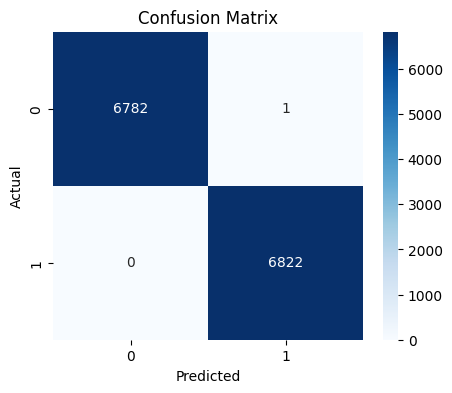

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


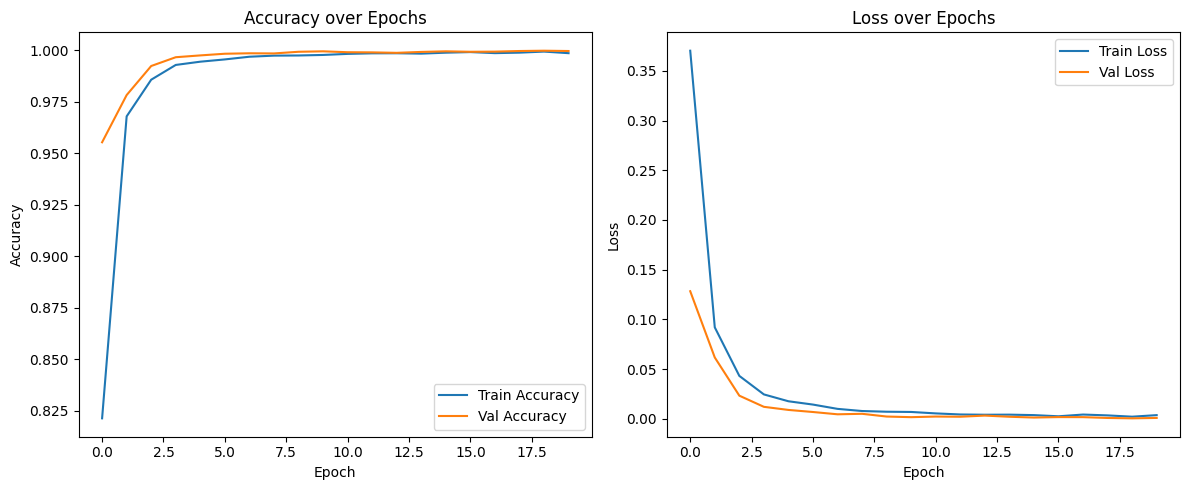

In [67]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1.0


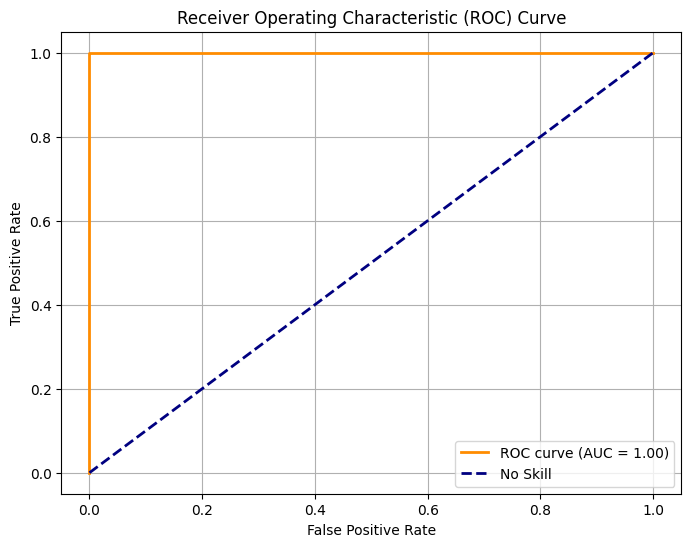

In [68]:
# AUC-ROC Curve
y_probs = model.predict(image_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, y_probs))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()